In [123]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Курс по машинному обучению,   ВМК МГУ
# KNN: Классификация и регрессия

### Важно! О формате сдачи

* **Задания из ноутбука, за исключением двух заданий на реализацию кода, оцениваются по системе <font color='red'>кросс-рецензирования</font>.**
* **При решении ноутбука используйте данный шаблон. Не нужно удалять текстовые ячейки c разметкой частей ноутбука и формулировками заданий. Добавлять свои ячейки, при необходимости, конечно можно**
* **Везде, где в формулровке задания есть какой-либо вопрос (или просьба вывода), необходимо прописать ответ в ячейку (код или markdown).**
* **Наличие кода решения обязательно. Письменные ответы на вопросы без сопутствующего кода оцениваются в 0 баллов.**

### Важно!

**Перед тем, как сдать ноутбук на кросс-рецензирование, мы рекомендуем перезапустить ядро и выполнить весь ноутбук (cell -> run all)**

# Часть 0. Знакомство с библиотекой scikit-learn

Scikit-learn - это библиотека машинного обучения с открытым исходным кодом, которая предоставляет различные инструменты для предобработки данных и обучения моделей.

Каждый модуль предобработки данных имеет два метода: fit и transform. Как правило, метод fit принимает на вход **обучающую** выборку $X$ и считает по ней необходимые для заданного типа преобразования статистики. Метод transform преобразует входные **(train и test)** данные, используя статистики, посчитанные при вызове метода fit и возвращает преобразованные данные.

Каждая модель машинного обучения имеет два метода: fit - метод ответственный за обучения модели и predict - метод ответственный за предсказание целевой переменной. Многие модели имеют метод predcit_proba, который возвращает вероятность принадлежности объекта к каждому из классов. Как правило, метод fit принимает на вход два аргумента: $X$ - **обучающая** выборка, $y$ - значения целевых переменных на объектах обучающей выборки. Метод predict принимает на вход набор данных и выдает предсказанные значения целевых переменных на этом наборе данных.

Более подробно про библиотеку можно прочитать в документации по [ссылке](https://scikit-learn.org/stable/index.html)

# Часть 1. Нормализация признакового пространства

В задачах машинного обучения важную роль играет нормализация данных. Для числовых признаков, как правило, используют два типа нормализации:

* Нормализация к распределению с нулевым матожиданием и единичной дисперсией $x := \frac{x - E(x)}{\sigma (x)}$, где матожидание $E(x)$ и стандартное отклонение $\sigma (x)$ считаются по каждому признаку (столбцу) отдельно
* Нормализация в отрезок [0, 1] $x := \frac{x - \min(x)}{\max(x) - \min(x)}$, где минимум и максимум берется по каждому признаку (столбцу) отдельно

Рассмотрим пример. Ниже приведены: таблца до нормализации признаков, таблица после нормализации к нулевому матожиданию и единичной дисперсии, таблица после нормализации в отрезок [0, 1]

До нормализации 

| Признак 1   | Признак 2   |
| ----------- | ----------- |
| 1           | 2           |
| 2           | -1          |
| 3           | 0           |

Нормализация к нулевому матожиданию и единичной дисперсии

| Признак 1   | Признак 2   |
| ----------- | ----------- |
| -1.225      | 1.336       |
| 0           | -1.069      |
| 1.225       | -0.267      |

Нормализация в отрезок [0, 1]

| Признак 1   | Признак 2   |
| ----------- | ----------- |
| 0           | 1           |
| 0.5         | 0           |
| 1           | 0.333       |

**Задание 1.1** (тесты, 5 баллов) В модуле scalers.py реализуйте два вида нормализации признакового пространства. StandardScaler - нормализация к распределению с нулевым матожиданием и единичной дисперсией, MinMaxScaler - нормализация в отрезок [0, 1].

Нормализаторы имеют два метода - метод fit и метод transform. Метод fit получает на вход **обучающую** выборку и считает по ней все необходимые для заданного преобразования статистики. Метод transform преобразует данные, используя статистистики, посчитанные при вызове метода fit.

Положите файл scalers.py в одну директорию с jupyter ноутбуком

In [124]:
from scalers import StandardScaler, MinMaxScaler

In [125]:
import numpy as np
import seaborn as sns
import pickle

from matplotlib import pyplot as plt


plt.rcParams["figure.figsize"] = (5,5)

Загрузим данные в память. В переменной $X$ будут храниться признаковые описания объектов, в переменной $y~-$ метки классов

In [126]:
with open('data.pkl', 'rb') as file:
    X, y = pickle.load(file)

In [127]:
def plot_data_points(X, labels, xlim, ylim):
    g = sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=labels)
    g.set(xlim=xlim, ylim=ylim)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid()

Визуализируем наши данные

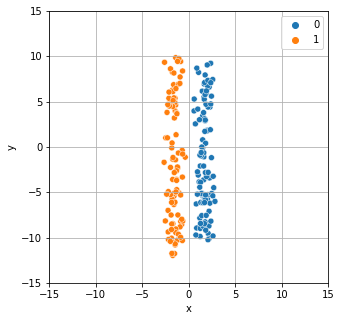

In [128]:
plot_data_points(X, y, xlim=(-15, 15), ylim=(-15, 15))

Как видно, наши данные идеально разделяются прямой $x=0$

Функция $plot\_knn\_bound$ принимает на вход объекты $X$, метки классов $y$, метод нормализации признаков $scaler$, число соседей $n\_neighbors$ и границы рисунка $xlim$, $ylim$. Функция обучает $KNN$ классификатор с числом соседей $n\_neighbors$ и визуализирует разделяющую поверхность для классов, полученную с помощью обученного $KNN$ классификатора.

* Если вы не можете различить _выбранные нами цвета_, то измените список цветов в переменных cmap_light и cmap_bold. Актуальный список возможных цветов находится [здесь](https://matplotlib.org/stable/tutorials/colors/colormaps.html)

In [129]:
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets

def plot_knn_bound(X, y, scaler=None, n_neighbors=10, xlim=(-15, 15), ylim=(-20, 20)):
    # step size in the mesh
    h = 0.05

    # Create color maps
    cmap_light = ListedColormap(['C0', 'orange', 'cyan', 'green'][:np.unique(y).shape[0]])
    cmap_bold = ['C0', 'orange', 'c', 'darkgreen'][:np.unique(y).shape[0]]

    x_min, x_max = xlim
    y_min, y_max = ylim
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    X_scaled = X # if scaler is None
    if scaler is not None:
        grid = scaler.transform(grid)
        X_scaled = scaler.transform(X)

    # we create an instance of Neighbours Classifier and fit the data.
    clf = neighbors.KNeighborsClassifier(n_neighbors, algorithm='brute')
    clf.fit(X_scaled, y)

    Z = clf.predict(grid)

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=cmap_light)

    #     # Plot also the training points
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y,
                    palette=cmap_bold, alpha=1.0, edgecolor="black")
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Разделющие поверхности алгоритма {}-NN'.format(n_neighbors))
    plt.grid()
    plt.show()

Нарисуем разделющие поверхности $1$-$NN$ и $10$-$NN$

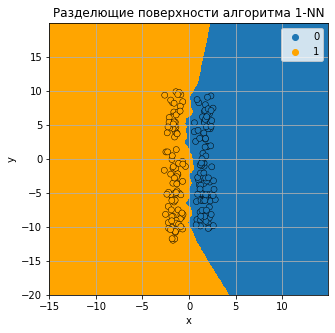

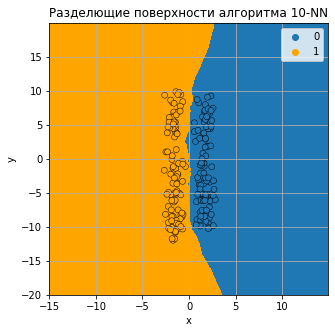

In [130]:
plot_knn_bound(X, y, n_neighbors=1)
plot_knn_bound(X, y, n_neighbors=10)

**Задание 1.2** (кросс, 2 балла) Чем отличаются поверхности, полученные при числе соседей 1 и 10? Объясните, чем вызваны данные отличия

ВАШ ОТВЕТ: Разделяющая кривая имеет более гладкий вид посередине при K = 10, чем при К = 1. Для метода KNN свойственно сглаживание разделяющей прямой при увеличении K

**Задание 1.3** (кросс, 3 балла) Объясните, почему наблюдается сильное отклоенние разделяющей поверхности от прямой $x=0$ при значениях $y < -10$ и $y > 10$

ВАШ ОТВЕТ: Объектов класса 1 в части |y| > 10 больше, чем объектов класса 0 => они оказывабт большее влияние на объекты из тестовой выборки с |y| > 10.

Данную проблему может решить нормализация признакового пространства. 

**Задание 1.4** (кросс, 1 балл) Начертите разделяющие поверхности для $KNN$, обученного на нормализованных признаках с помощью реализованных вами нормализаторов. Используйте функцию $plot\_knn\_bound$

In [131]:
with open('data.pkl', 'rb') as file:
    X, y = pickle.load(file)

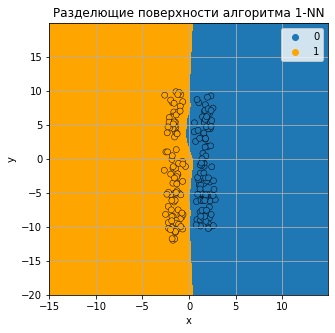

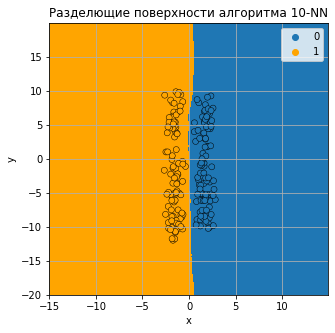

In [132]:
scaler = StandardScaler()
scaler.fit(X)
plot_knn_bound(X, y, scaler = scaler, n_neighbors=1)
plot_knn_bound(X, y, scaler = scaler, n_neighbors=10)

**Задание 1.5** (кросс, 4 балла) Пусть дано произвольное число точек на плоскости. Представим, что каждая точка - это отдельный класс. Пусть на данной выборке был обучен $1$-$NN$ классификатор. Чем с геометрической точки зрения являются раделяющие поверхности этого классификатора? Приведите доказательство для произвольного числа точек

В качестве примера ниже представлена визуализация для четырех точек

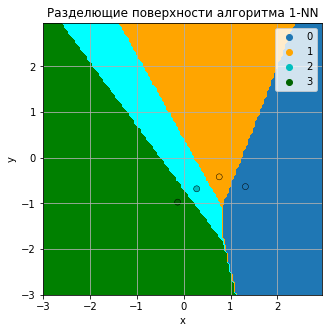

In [133]:
X = np.random.randn(4, 2)
y = np.arange(4)
plot_knn_bound(X, y, n_neighbors=1, xlim=(-3, 3), ylim=(-3, 3))

ВАШ ОТВЕТ: Разделяющие поверхности этого классификатора являются многоугольниками с геометрической точки зрения.

Док-во: Любые разделяющие поверхности между любыми классами - прямые (срединные перпендикуляры) => образованные этими прямыми фигуры - многоугольникиугольники => для каждого класса, обходя эти разделяющие прямые, получим область - многоугольник, охватывающий этот класс 

# Часть 2. Кросс-валидация на задаче регрессии

При решении прикладных задач, как правило, доступна лишь обучающая выборка. Для того чтобы иметь возможность оценить качество модели на тестовой выборке, прибегают к методу, называемому кросс-валидация. Пусть зафиксирован некоторый набор параметров модели. В $KNN$ под параметрами могут пониматься число соседей, метрика близости $\rho$, стратегия выбора весов $w_i$. При кросс-валидации **обучающая** выборка делится на $n$ равных частей (folds). Затем обучаются $n$ моделей с заданными параметрами (у всех моделей параметры одинаковые и фиксированы) - $i$-ая модель обучается на всей обучающей выборке, кроме объектов, которые попали в $i$-ый фолд (out-of-fold). Затем измеряется качество $i$-ой модели на $i$-ом фолде. Так как он не участвовал в обучении этой модели, то полученная оценка качества модели будет являться корректной. Финальным значением метрики качества для модели с заданными параметрами является среднее полученных нами значений на $n$ фолдах.

Принцип работы кросс-валидации схематично изображен на рисунке.

<img src="cross-val.png" style="width: 700px;">

**Задание 2.1** (тест, 10 баллов) В модуле cross\_val.py реализуйте функции

* $kfold\_split$, которая реализует генерацию индексов обучающей и валидационной выборок для кросс-валидации
* $knn\_cv\_score$, которая реализует кросс-валидацию для $KNN-$модели

Далее будем решать задачу предсказания цены дома в Бостоне с помощью $KNN$-регрессии. В качестве метрики качества будем использовать $R^2-$score.

$R^2(y\_true, y\_predict) = 1 - \frac{\sum_{i=1}^{n} (y\_true_i - y\_predict_i)^2}{\sum_{i=1}^{n} (y\_true_i - E(y\_true))^2}$

Наилучшее значение метрики равно $1.0$, метрика может принимать отрицательные значения

In [134]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

In [135]:
X, y = load_boston(return_X_y=True)

**Задание 2.2** (кросс, 1 балл) Разбейте выборку на обучающую (75%) и тестовую (25%) с помощью функции $train\_test\_split$. Используйте параметр **random_state=42!** Не забудьте перемешать данные перед разбиением (см. параметры функции). Запустите кросс-валидацию на 3 фолдах с помощью реализованных вами функций $kfold\_split$, $knn\_cv\_score$. В качестве метрики используйте $r2\_score$. Параметры для перебора описаны ниже

In [136]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [137]:
from sklearn.metrics import r2_score

parameters = {
    'n_neighbors': [1, 5, 10],
    'metrics': ['euclidean', 'cosine'],
    'weights': ['uniform', 'distance'],
    'normalizers': [(None, 'None'), (MinMaxScaler(), 'MinMax'), (StandardScaler(), 'Standard')]
}
score_function = r2_score

Положите файл cross_val.py в одну директорию с jupyter ноутбуком

In [138]:
from cross_val import kfold_split, knn_cv_score
split = kfold_split(len(X_train), 3)
ans = knn_cv_score(X_train, y_train, parameters, score_function, splites, neighbors.KNeighborsRegressor)

**Задание 2.3** (кросс, 3 балла) Какой наибольший $r2\_score$ удалось достичь на валидации? Какие закономерности вы видите? Обучите модель с наилучшими параметрами на всей обучающей выборке, измерьте $r2\_score$ на тестовой выборке.

Выведите результаты кросс-валидации

In [139]:
import operator
list = sorted( ans.items(), key = operator.itemgetter(1), reverse = True)
ans = {a: b for a, b in list}
print(ans)

{('MinMax', 5, 'cosine', 'distance'): 0.7838913979622365, ('Standard', 10, 'cosine', 'distance'): 0.7801368630961365, ('Standard', 5, 'cosine', 'distance'): 0.7734933476304353, ('Standard', 5, 'euclidean', 'distance'): 0.76086114026528, ('MinMax', 10, 'cosine', 'distance'): 0.7593662843362762, ('Standard', 10, 'euclidean', 'distance'): 0.7466700102355973, ('MinMax', 5, 'euclidean', 'distance'): 0.7309097149007378, ('Standard', 1, 'euclidean', 'uniform'): 0.7277979012952706, ('Standard', 1, 'euclidean', 'distance'): 0.7277979012952703, ('MinMax', 1, 'euclidean', 'distance'): 0.7205015731772787, ('MinMax', 1, 'euclidean', 'uniform'): 0.7205015731772786, ('Standard', 1, 'cosine', 'uniform'): 0.7175103068303716, ('Standard', 1, 'cosine', 'distance'): 0.7175103068303716, ('MinMax', 1, 'cosine', 'uniform'): 0.710556859845133, ('MinMax', 1, 'cosine', 'distance'): 0.710556859845133, ('Standard', 10, 'cosine', 'uniform'): 0.7096596518668199, ('Standard', 10, 'euclidean', 'uniform'): 0.702222269

ВАШ ОТВЕТ: 

1) Лучший r2_score: 0.7838913979622365

2) Более высокие показатели получаются при использовании весов, зависящих от расстояноя (distance) и с метрикой cosine. Также выбиваются модель StandardScaler

Обучите модель с лучшими по валидации параметрами на обучающей выборке

# Часть 3. Работа с текстовыми данными

Далее будем решать задачу классификации новостного текста к одному из 20 классов, каждый класс соответствует определенной новостной тематике. В качестве метрики качества будем использовать $accuracy\_score$. Accuracy - это доля верно классифицированных объектов, среди всех объектов выборки.

In [140]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [141]:
X_train, y_train = fetch_20newsgroups(subset='train', return_X_y=True, random_state=42)
X_test, y_test = fetch_20newsgroups(subset='test', return_X_y=True, random_state=42)
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [142]:
print(X_train[0])

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







Как мы видим, объектами обучающей выборки являются тексты. Сырые текстовые данные не могут служить обучающими примерами для алгоритма $KNN$. Перед использованием $KNN$ текстовые данные переменной длины необходимо отобразить в метрическое пространство фиксированной размерности.

Работа с текстовыми данными проходит в несколько этапов.

* **Токенизация.** Текстовая строка делится на токены. Как правило, в качестве токенов выступают отдельные слова и знаки препинания.

* **Нормализация.** Приведение к нижнему регистру, удаление стоп-слов, удаление пунктуации, удаление редких и частотных слов и т.д.

* **Векторизация.** Фиксируется словарь токенов $V$ по **обучающей** выборке. Текст представлется в виде вектора длиной $|V|$, где каждый признак есть функция от частоты встречаемости токена в тексте и в обучающей выборке.

В данном задании будет использовано два вида векторизации. Первый, $CountVectorizer$, сопоставляет каждому токену частоту встречаемости этого токена в тексте документа. Второй, $TfidfVectorizer$, сопоставляет каждому токену частоту встречаемости этого токена в тексте документа умноженную на величину обратно пропорциональную частоте встречаемости токена во всех документах **обучающей** выборки. Подробне про $tf-idf$ можно прочитать [здесь](https://ru.wikipedia.org/wiki/TF-IDF).

В sklearn все векторизаторы автоматически токенизируют текст и приводят его к нижнему регистру. Параметры $max\_df$ и $min\_df$ позволяют убрать из словаря наиболее частые и наиболее редкие токены. Параметр $stop\_words$ позволяет убрать из словаря стоп-слова (малоинформативные слова для данного языка, например, союзы).

In [143]:
count_vec = CountVectorizer(max_df=0.8, min_df=10, stop_words='english')
tf_idf = TfidfVectorizer(max_df=0.8, min_df=10, stop_words='english')

**Задание 3.1** (кросс, 2 балла) Найдите оптимальные параметры обучения модели. Осуществлять перебор параметров следует по заданной ниже сетке. Используйте реализованные вами функции $kfold\_split$, $knn\_cv\_score$. В качестве метрики используйте $accuracy\_score$.

In [144]:
from sklearn.metrics import accuracy_score

parameters = {
    'n_neighbors': [i for i in range(1, 11)],
    'metrics': ['euclidean', 'cosine'],
    'weights': ['uniform', 'distance'],
    'normalizers': [(count_vec, 'CountVectorizer'), (tf_idf, 'TfidfVectorizer')]
}

In [145]:
#ваш код

**Задание 3.2** (кросс, 2 балла) Какой метод предобработки данных в среднем дает наилучший результат? Почему?

In [146]:
# ваш код

ВАШ ОТВЕТ

**Задание 3.3** (кросс, 2 балла) Какая метрика близости позволяет в среднем достичь наилучшее качество? Почему?

In [147]:
# ваш код

ВАШ ОТВЕТ

**Задание 3.4** (кросс, 2 балла) Начертите график зависимости метрики качества от числа соседей. Метрику следует усреднить по всем параматрам, кроме числа соседей. Сделайте выводы о наблюдаемых зависимостях (возможно будет полезным ознакомиться с названиями классов)

In [148]:
# ваш код

ВАШ ОТВЕТ

**Задание 3.5** (кросс, 3 балла) Оцените точность вашей лучшей модели на тестовой части датасета. Отличается ли оно от качества, полученного на кросс-валидации? Почему?

In [149]:
#ваш код

ВАШ ОТВЕТ

**(!)** А теперь перезапустите ноутбук: Kernel -> Restart & Run All